# shLars polysome profiling

In [ ]:
%%bash
ls | head

### Trimming task

In [ ]:
%%bash
# Trimming task
for f1 in *_R1_001.fastq.gz; do
	out1=${f1/_001.fastq.gz/.trim.fastq.gz}
	cutadapt -j 12 -q 15 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCAC -o $out1 $f1 >> log.txt
done

### Alignment task

In [ ]:
%%bash
for f1 in *_R1.trim.fastq.gz; do
	out=${f1/_R1.trim.fastq.gz/_}
	echo "STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 1 --sjdbGTFfile /rumi/shams/genomes/mm10/mm10_genes.gtf  --genomeDir /rumi/shams/genomes/mm10 --readFilesIn $f1 --outFileNamePrefix $out"
 STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 8 --sjdbGTFfile /rumi/shams/genomes/mm10/mm10_genes.gtf  --genomeDir /rumi/shams/genomes/mm10 --readFilesIn $f1 --outFileNamePrefix $out
done

### Measure counts

In [ ]:
%%bash
for f in *_Aligned.sortedByCoord.out.bam; do
	out=${f/.bam/.gene.fc}
	echo "---";
	featureCounts -T 12 -O -t exon -g gene_id -a /rumi/shams/genomes/mm10/mm10_genes.gtf -o $out $f;
done

# Load R

In [1]:
%load_ext rpy2.ipython

In [40]:
%%R
library(DESeq2,  quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
library(ggpubr, quietly = TRUE)

## Read data 

In [7]:
%%R
files <- list.files(pattern=".fc$")
files_order <- c()
files_new <- rep("",27)
for (i in files){files_order <- append(files_order, as.numeric(strsplit (i,'_')[[1]][1]))}
i <- 1
for (f in files_order){	files_new[f] = files[i]
i <- i+1}
files <- files_new

sample.type <- c(rep("Input",6), rep("Low",6), rep("High", 6),
		rep("Input",3), rep("Low",3), rep("High", 3))
cell.line   <- c(rep(c(rep("Ctrl",2),rep("shLars",2),rep("shLars",2)), 3),
		 rep(c("Ctrl","shLars","shLars"), 3))
replicate <- c(rep(c('rep_1','rep_2'),9), rep('rep_3',9))
batch <- c(rep('btch_1',18),rep('btch_2',9))
all_cond <- paste(sample.type, cell.line, replicate, batch, sep="_")
cond <- paste(sample.type, cell.line, sep="_")

datalist <- lapply(files, function(x){read.table(file=x,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- gsub("_Aligned.sortedByCoord.out.bam", "", colnames(m))
colData <- data.frame(cond, row.names=colnames(m))

# DE Analysis

In [10]:
%%R
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond<- relevel(dds$cond, ref="Input_Ctrl")
dds <- DESeq(dds)
resultsNames(dds)
ncu <- counts(dds, normalized=TRUE)
write.table(ncu, file="gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=NA) 
write.table(m, file="gene_count_table_raw.txt", sep="\t", quote=FALSE, col.names=NA )
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates



### PCA 

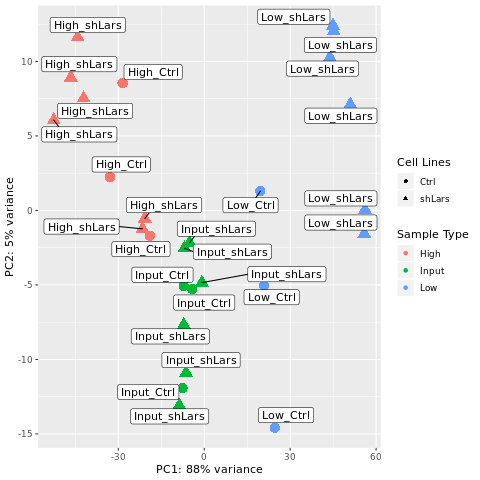

In [16]:
%%R
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4, color = sample.type, shape = cell.line)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = cond, force = 10) +
  labs(shape="Cell Lines", colour="Sample Type") +
  guides(size = FALSE)
print (p)

In [31]:
%%R
### Final Models
H_Ctrl <- "cond_High_Ctrl_vs_Input_Ctrl"
L_Ctrl <- "cond_Low_Ctrl_vs_Input_Ctrl"
I_Ctrl <- "condInput_Ctrl"
H_shLars <- "cond_High_shLars_vs_Input_Ctrl"
L_shLars <- "cond_Low_shLars_vs_Input_Ctrl"
I_shLars <- "cond_Input_shLars_vs_Input_Ctrl"

### Model 1. 
# $$(H shLars - I shLars) - (H Ctrl - I Ctrl)$$

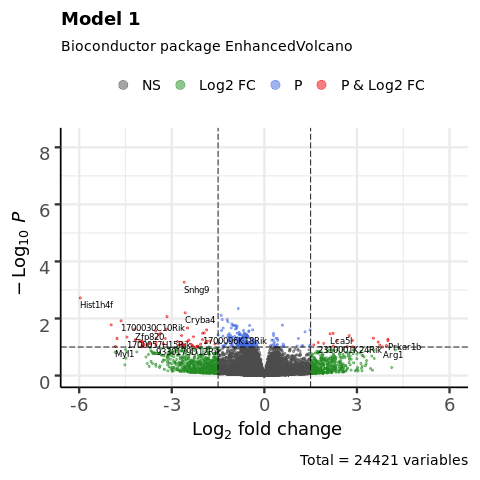

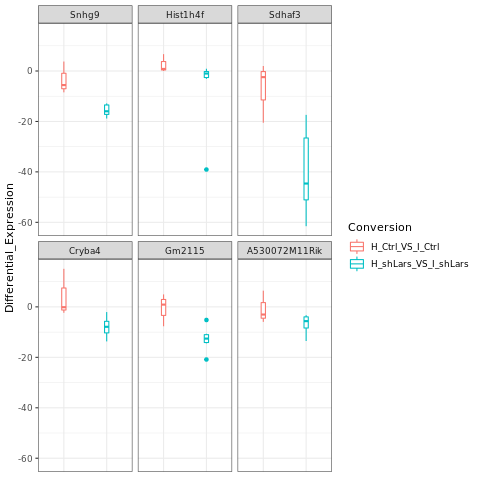

In [126]:
%%R
res1 <- results(dds, contrast=list(c(H_shLars),c(I_shLars,H_Ctrl)), listValues=c(1,-1))
write.table(res1, "H_shLars-I_shLars_VS_H_Ctrl-I_Ctrl.txt", sep="\t", quote=FALSE, col.names=NA )
# Volcano plot 
vol1 <- EnhancedVolcano(res1,
    lab = rownames(res1),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-6, 6),
    title = 'Model 1',
    pCutoff = 10e-2,
    FCcutoff = 1.5)
print (vol1)

# check top genes 
top_genes <- rownames(head(res1[order(res1$pvalue),]))
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
                        'Differential_Expression' = c(
                            ncu[top_genes[g],rownames(subset (colData,cond == 'High_shLars'))] -
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Input_shLars'))],
                            ncu[top_genes[g],rownames(subset (colData,cond == 'High_Ctrl'))] -
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Input_Ctrl'))]),
                        'Conversion' = c(rep('H_shLars_VS_I_shLars',6),rep('H_Ctrl_VS_I_Ctrl',3)),
                        'Gene' = top_genes[g]))
}
ggplot(data = check, mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1)+
    scale_fill_grey() +
    theme_bw() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+
    facet_wrap(facets = vars(Gene))

### Model 2. 
# $$(L shLars - I shLars) - (L Ctrl - I Ctrl)$$

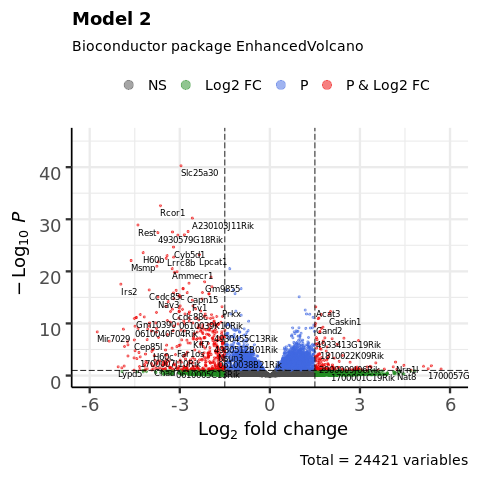

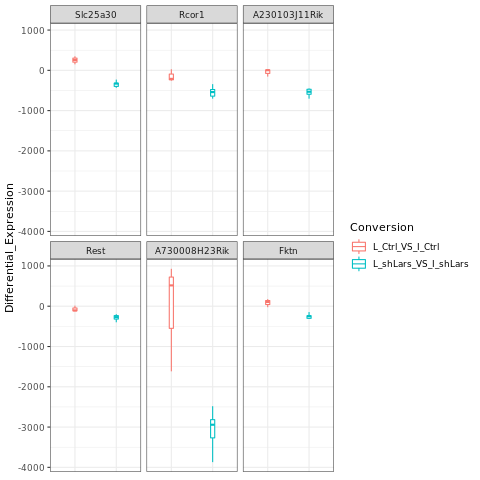

In [121]:
%%R
res2 <- results(dds, contrast=list(c(L_shLars),c(I_shLars,L_Ctrl)), listValues=c(1,-1))
write.table(res2, "L_shLars-I_shLars_VS_L_Ctrl-I_Ctrl.txt", sep="\t", quote=FALSE, col.names=NA )

# Volcano plot 
vol2 <- EnhancedVolcano(res2,
    lab = rownames(res2),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-6, 6),
    title = 'Model 2',
    pCutoff = 10e-2,
    FCcutoff = 1.5)
print (vol2)

# check top genes 
top_genes <- rownames(head(res2[order(res2$pvalue),]))
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
                        'Differential_Expression' = c(
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Low_shLars'))] -
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Input_shLars'))],
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Low_Ctrl'))] -
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Input_Ctrl'))]),
                        'Conversion' = c(rep('L_shLars_VS_I_shLars',6),rep('L_Ctrl_VS_I_Ctrl',3)),
                        'Gene' = top_genes[g]))
}
ggplot(data = check, mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1)+
    scale_fill_grey() +
    theme_bw() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+
    facet_wrap(facets = vars(Gene))

### Model 3. 
# $$(H shLars - L shLars) - (H Ctrl - L Ctrl)$$

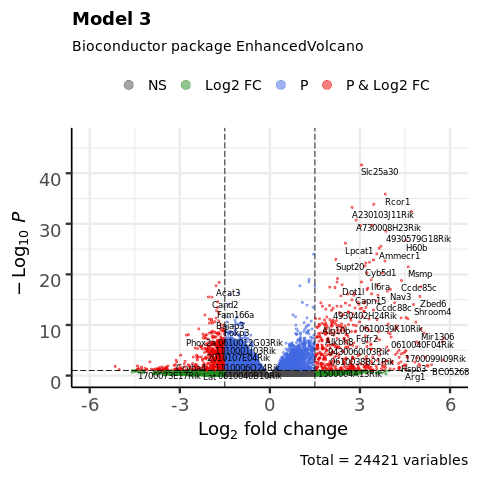

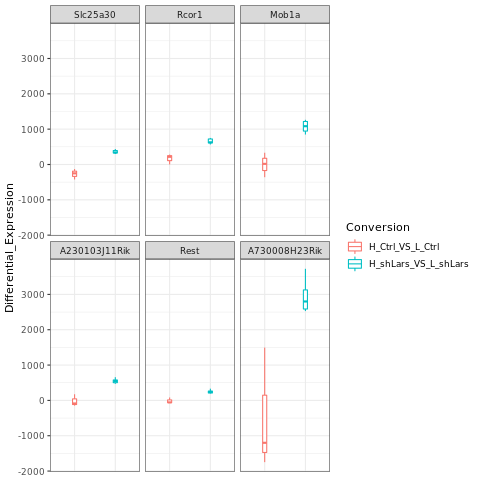

In [122]:
%%R
res3 <- results(dds, contrast=list(c(H_shLars,L_Ctrl),c(L_shLars,H_Ctrl)), listValues=c(1,-1))
write.table(res3, "H_shLars-L_shLars_VS_H_Ctrl-L_Ctrl.txt", sep="\t", quote=FALSE, col.names=NA )

# Volcano plot 
vol3 <- EnhancedVolcano(res3,
    lab = rownames(res3),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-6, 6),
    title = 'Model 3',
    pCutoff = 10e-2,
    FCcutoff = 1.5)
print (vol3)

# check top genes 
top_genes <- rownames(head(res3[order(res3$pvalue),]))
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
                        'Differential_Expression' = c(
                            ncu[top_genes[g],rownames(subset (colData,cond == 'High_shLars'))] -
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Low_shLars'))],
                            ncu[top_genes[g],rownames(subset (colData,cond == 'High_Ctrl'))] -
                            ncu[top_genes[g],rownames(subset (colData,cond == 'Low_Ctrl'))]),
                        'Conversion' = c(rep('H_shLars_VS_L_shLars',6),rep('H_Ctrl_VS_L_Ctrl',3)),
                        'Gene' = top_genes[g]))
}
ggplot(data = check, mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1)+
    scale_fill_grey() +
    theme_bw() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+
    facet_wrap(facets = vars(Gene))